In [520]:
import numpy as np
import pandas as pd
from collections import Counter
import time

import matplotlib.pyplot as plt

%matplotlib inline

In [521]:
np.random.seed(1)

In [522]:

movies = ["Avengers", "Avengers: Infinity War",
          "Stardust", "Princess Bride", "Last Witchhunter", "Tall Girl"]
users = ["Kateřina", "Jirka", "Václav", "Jan"]

"""
movies = [ "movie{}".format(idx) for idx in range(10) ]
"""

n_movies = len(movies)
n_users = len(users)

user_movie_matrix = np.random.randint(1, 6, size=(n_users, n_movies))

In [523]:
knowledge_base_data = pd.read_csv("c:/Users/jfili/Downloads/sparql (4)")
knowledge_base_data["genre"] = "genre"
knowledge_base_data = knowledge_base_data[["movie", "genre", "subject"]]

In [524]:
knowledge_base_sparql_triples = knowledge_base_data.values

In [525]:
user_movie_df = pd.DataFrame(user_movie_matrix, index=users, columns=movies)
user_movie_df

,Avengers,Avengers: Infinity War,Stardust,Princess Bride,Last Witchhunter,Tall Girl
Kateřina,4,5,1,2,4,1
Jirka,1,2,5,5,2,3
Václav,5,3,5,4,5,3
Jan,5,3,5,2,2,1


In [526]:
predicates = dict(
    genre=["Fantasy", "Comedy", "Action", "Adventure", "Drama", "Sci-fi", "Thriller", "Teen", "Adult"]
)

def generate_knowledge_base(items):
    knowledge_base = []
    
    for item in items:
        for predicate in predicates.keys():
            options = predicates[predicate]
            n_options = len(options)
            
            object_subset = np.random.choice(options, np.random.randint(1, n_options + 1))

            for chosen_object in object_subset:
                knowledge_base.append((item, predicate, chosen_object))

    return knowledge_base

knowledge_base = generate_knowledge_base(movies)

In [527]:
knowledge_base

[('Avengers', 'genre', 'Teen'),
 ('Avengers', 'genre', 'Thriller'),
 ('Avengers', 'genre', 'Comedy'),
 ('Avengers', 'genre', 'Fantasy'),
 ('Avengers', 'genre', 'Comedy'),
 ('Avengers', 'genre', 'Adult'),
 ('Avengers', 'genre', 'Adult'),
 ('Avengers: Infinity War', 'genre', 'Adult'),
 ('Avengers: Infinity War', 'genre', 'Teen'),
 ('Avengers: Infinity War', 'genre', 'Adventure'),
 ('Avengers: Infinity War', 'genre', 'Thriller'),
 ('Stardust', 'genre', 'Comedy'),
 ('Stardust', 'genre', 'Adventure'),
 ('Stardust', 'genre', 'Drama'),
 ('Stardust', 'genre', 'Adult'),
 ('Stardust', 'genre', 'Comedy'),
 ('Stardust', 'genre', 'Drama'),
 ('Princess Bride', 'genre', 'Adventure'),
 ('Last Witchhunter', 'genre', 'Fantasy'),
 ('Last Witchhunter', 'genre', 'Drama'),
 ('Last Witchhunter', 'genre', 'Action'),
 ('Tall Girl', 'genre', 'Teen'),
 ('Tall Girl', 'genre', 'Adult'),
 ('Tall Girl', 'genre', 'Thriller'),
 ('Tall Girl', 'genre', 'Adventure'),
 ('Tall Girl', 'genre', 'Teen'),
 ('Tall Girl', 'genre

In [503]:
#F
all_possible_features_F = list({ (predicate, obj) for (item, predicate, obj) in knowledge_base })

all_possible_features_F

[('genre', 'Sci-fi'),
 ('genre', 'Adventure'),
 ('genre', 'Fantasy'),
 ('genre', 'Comedy'),
 ('genre', 'Action'),
 ('genre', 'Adult'),
 ('genre', 'Teen'),
 ('genre', 'Thriller'),
 ('genre', 'Drama')]

In [512]:
class TFIDFTransformer:
    
    def __init__(self, knowledge_base_triples, x_matrix, user_names, item_names):
        
        self.x_matrix = x_matrix
        
        self.user_names = user_names
        self.item_names = item_names
        self.n_users, self.n_items = x_matrix.shape
        self.knowledge_base_triples = knowledge_base_triples
        self.all_possible_features_F = list({ (predicate, obj) for
                                             (item, predicate, obj)
                                             in knowledge_base_triples })
        
        self.v_matrix = None
        self.v_matrix_users = None
        self.v_matrix_items = None
        
        
    def generate_v_for_item(self, current_item, feature):
        feature_predicate, feature_object = feature
        tf_numerator = 1 if (current_item, feature_predicate, feature_object) in self.knowledge_base_triples else 0

        tf_denominator = 0
        for current_predicate, current_obj in self.all_possible_features_F:
            predicates = { (predicate, obj) for (item, predicate, obj) in self.knowledge_base_triples
                         if current_item == item and current_predicate == predicate and current_obj == obj }
            n_predicates = len(predicates)

            tf_denominator += n_predicates**2

        tf_denominator = np.sqrt(tf_denominator)

        idf_numerator = self.n_items
        idf_denominator = len({ item for (item, predicate, obj) in self.knowledge_base_triples
                              if feature_predicate == predicate and feature_object == obj })

        v_value = tf_numerator / tf_denominator * np.log(idf_numerator / idf_denominator)

        return v_value
    
    
    def generate_v_for_user(self, user, feature):
        feature_idx = self.all_possible_features_F.index(feature)
        user_idx = self.user_names.index(user)

        items_enjoyed_by_user = [ item_idx 
                                 for item_idx, user_enjoyment 
                                 in enumerate(self.x_matrix[user_idx, :])
                                 if user_enjoyment == 1 ]    

        u_numerator = np.sum(self.v_matrix_items[items_enjoyed_by_user, feature_idx])
        u_denominator = len({ movie_idx for movie_idx in items_enjoyed_by_user
                            if self.v_matrix_items[movie_idx, feature_idx] != 0 })

        if u_denominator == 0:
            return u_denominator

        u_value = u_numerator / u_denominator

        return u_value
    
    
    def generate_v_item_matrix(self):
        v_matrix = np.zeros((self.n_items, len(self.all_possible_features_F)))

        for i, item in enumerate(self.item_names):
            for j, (predicate, obj) in enumerate(self.all_possible_features_F):
                v_matrix[i, j] = self.generate_v_for_item(item, (predicate, obj))

        self.v_matrix_items = v_matrix
        
        
    def generate_v_user_matrix(self):
        u_matrix = np.zeros((self.n_users, len(self.all_possible_features_F)))

        for i, user in enumerate(self.user_names):
            for j, (predicate, obj) in enumerate(self.all_possible_features_F):
                u_matrix[i, j] = self.generate_v_for_user(user, (predicate, obj))

        self.v_matrix_users = u_matrix
        
    def generate_v_matrix(self):
        self.generate_v_item_matrix()
        self.generate_v_user_matrix()
        
        self.v_matrix = np.concatenate([self.v_matrix_users, self.v_matrix_items])


In [505]:
tfidf = TFIDFTransformer(knowledge_base, user_movie_matrix, users, movies)

In [506]:
tfidf2 = TFIDFTransformer(knowledge_base_sparql_triples, user_movie_matrix, users, movies)

In [507]:
a = [ (predicate, obj) for (item, predicate, obj) in knowledge_base_sparql_triples ]
ctr = Counter(a)
features_only = [ feature for (feature, _) in ctr.most_common(25) ]
knowledge_base_new = [ (subj, pred, obj) for (subj, pred, obj) in knowledge_base_sparql_triples if (pred, obj) in features_only ]

In [508]:
movies = list(set([subj for subj, *_ in knowledge_base_sparql_triples]))
users = [ "user{}".format(idx) for idx in range(4) ]

"""
movies = [ "movie{}".format(idx) for idx in range(10) ]
users = [ "user{}".format(idx) for idx in range(10) ]
"""
n_movies = len(movies)
n_users = len(users)

user_movie_matrix = np.random.randint(0, 2, size=(n_users, n_movies))


tfidf2 = TFIDFTransformer(knowledge_base_new, user_movie_matrix, users, movies)

In [509]:
tfidf2.generate_v_matrix()
tfidf2.v_matrix

array([[0.7501616 , 0.        , 0.05981511, ..., 0.        , 1.1388712 ,
        0.64180192],
       [0.76218064, 0.        , 0.05543104, ..., 0.        , 1.08699693,
        0.7315711 ],
       [0.72034051, 0.84516486, 0.05633309, ..., 0.88752928, 1.12157978,
        0.66068918],
       ...,
       [0.        , 0.80280044, 0.03727101, ..., 0.        , 0.        ,
        0.54733052],
       [0.        , 0.        , 0.05528184, ..., 0.        , 1.19074548,
        0.        ],
       [0.        , 0.        , 0.06180698, ..., 0.        , 0.        ,
        0.        ]])

In [510]:
class BayesianPersonalRanking:
    
    def __init__(self):
        pass


class FactorizationMachine:
    
    def __init__(self, users, items, y, v_matrix):
        self.users = users
        self.items = items
        self.y = y
        
        self.training_data = None
        self.training_y = None
        
        self.w_bias = np.random.normal()
        self.w_pars = np.random.normal(size=n_users + n_movies)
        self.v_matrix = np.copy(v_matrix)
        
        
    
    def build_training_data(self):
        n_users = len(self.users)
        n_items = len(self.items)

        target_matrix = np.zeros(shape=(n_users * n_items, n_users + n_items))
        target_matrix_y = np.zeros(n_users * n_items)

        row_counter = 0
        for user_idx, user in enumerate(self.users):
            for item_idx, item in enumerate(self.items):
                target_matrix[row_counter, user_idx] = 1
                target_matrix[row_counter, (n_users - 1) + item_idx] = 1

                target_matrix_y[row_counter] = self.y[user_idx, item_idx]
                
                row_counter += 1


        self.training_data = target_matrix
        self.training_y = target_matrix_y
        
        
    def predict(self, user_idx, item_idx):
        n = self.training_data.shape[0]
        n_users = len(self.users)
        n_items = len(self.items)
        
        x_hat = self.w_bias + self.w_pars[user_idx] + self.w_pars[n_users + item_idx] + self.v_matrix[user_idx, :]@self.v_matrix[user_idx + item_idx, :].T
        
        return x_hat
    
    
    def loss_MSE(self):
        
        y_hats = []
        
        for user_idx in range(len(self.users)):
            for item_idx in range(len(self.items)):
                y_hat = self.predict(user_idx, item_idx)
                y_hats.append(y_hat)
               
            
        y_hats = np.array(y_hats)
               
        mse = np.mean((y_hats - self.training_y)**2)
            
        return 1/2 * mse
    
    
    def loss_MSE_gradient(self, x_input):
        n_features = self.v_matrix.shape[1]
        n = self.v_matrix.shape[0]
        
        w_bias_gradient = -1
        w_pars_gradient = -x_input
        
        v_gradients = np.zeros_like(self.v_matrix)

        for idx_i in range(n):
            x_i = x_input[idx_i]
            x_i_vector = np.array([x_i**2] * n)
            
            for feature_idx in range(n_features):
                
                grad_sum = np.dot(self.v_matrix[:, feature_idx], x_input) - np.dot(self.v_matrix[:, feature_idx], x_i_vector)
                
                """
                for idx_j in range(n):
                    v_j_f = self.v_matrix[idx_j, feature_idx]
                    x_j = x_input[idx_j]
                    
                    v_i_f = self.v_matrix[idx_i, feature_idx]
                    
                    grad_sum += v_j_f * x_j - v_i_f * x_i**2
                """   
                   
                v_grad = x_i * grad_sum
                v_gradients[idx_i, feature_idx] = -v_grad
        
        
        
        
        return w_bias_gradient, w_pars_gradient, v_gradients
        
        
class SGD:
    
    def __init__(self, factorization_machine, iterations=500, learning_rate=0.01):
        self.factorization_machine = factorization_machine
        self.learning_rate = learning_rate
        self.iterations = iterations
        
        
    def fit(self):
        training_data = self.factorization_machine.training_data
        
        loss_data = []
        
        
        for i in range(self.iterations):
            print("iter %d" % i)
            bias_gradient = 0
            w_gradient = np.zeros_like(self.factorization_machine.w_pars)
            v_gradient = np.zeros_like(self.factorization_machine.v_matrix)
        
        
            for row_idx in range(training_data.shape[0]):
                current_bias_gradient, current_pars_gradient, current_v_gradient = self.factorization_machine.loss_MSE_gradient(training_data[row_idx, :])

                bias_gradient += current_bias_gradient
                w_gradient += current_pars_gradient
                v_gradient += current_v_gradient
            
            
            loss_MSE = self.factorization_machine.loss_MSE()
            bias_gradient *= loss_MSE
            w_gradient *= loss_MSE
            v_gradient *= loss_MSE
            
            """
            print("b grad", bias_gradient)
            print("w grad", w_gradient)
            print("v grad", v_gradient)
            """
            
            """
            print("b", self.factorization_machine.w_bias)
            print("w", self.factorization_machine.w_pars)
            print("v", self.factorization_machine.v_matrix)
            """
            
            
            print("loss MSE", loss_MSE)
            loss_data.append(loss_MSE)
            
            self.factorization_machine.w_bias -= self.learning_rate * bias_gradient
            self.factorization_machine.w_pars -= self.learning_rate * w_gradient
            self.factorization_machine.v_matrix -= self.learning_rate * v_gradient
            
            
        return loss_data
            
        

In [511]:
fm = FactorizationMachine(users, movies, user_movie_matrix, tfidf2.v_matrix)
fm.build_training_data()

fm.training_data
sgd = SGD(fm, iterations=10, learning_rate=0.0001)
loss1 = sgd.fit()

iter 0
loss MSE 11.944929449371301
iter 1
loss MSE 3.962974953069175
iter 2
loss MSE 3.352530425543364
iter 3
loss MSE 3.0457879787745585
iter 4
loss MSE 2.8746198770907117
iter 5
loss MSE 2.778901592124669
iter 6
loss MSE 2.7312806857521554
iter 7
loss MSE 2.717551044445555
iter 8
loss MSE 2.7297331479682296
iter 9
loss MSE 2.763156338872641


In [484]:
fm2 = FactorizationMachine(users, movies, user_movie_matrix, tfidf2.v_matrix)
fm2.build_training_data()

sgd2 = SGD(fm2, iterations=10, learning_rate=0.00001)
loss2 = sgd2.fit()

iter 0
loss MSE 10.436301917146368
iter 1
loss MSE 9.178059513485966
iter 2
loss MSE 8.211253440376602
iter 3
loss MSE 7.443735529271455
iter 4
loss MSE 6.818890852462105
iter 5
loss MSE 6.299891971190989
iter 6
loss MSE 5.861690029941574
iter 7
loss MSE 5.486624518444871
iter 8
loss MSE 5.161870053872753
iter 9
loss MSE 4.877878404732126


In [480]:
fm3 = FactorizationMachine(users, movies, user_movie_matrix, tfidf2.v_matrix)
fm3.build_training_data()

sgd3 = SGD(fm3, iterations=10, learning_rate=0.000001)
loss3 = sgd3.fit()

iter 0
loss MSE 10.938454795577154
iter 1
loss MSE 10.79555572551546
iter 2
loss MSE 10.656523857664832
iter 3
loss MSE 10.521204394965146
iter 4
loss MSE 10.389450697995624
iter 5
loss MSE 10.261123754205784
iter 6
loss MSE 10.136091688084715
iter 7
loss MSE 10.014229308629066
iter 8
loss MSE 9.895417690835483
iter 9
loss MSE 9.77954378826797


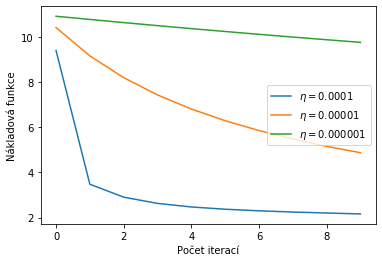

In [495]:
plt.plot(loss1, label="$\eta=0.0001$")
plt.plot(loss2, label="$\eta=0.00001$")
plt.plot(loss3, label="$\eta=0.000001$")
plt.xlabel("Počet iterací")
plt.ylabel("Nákladová funkce")
plt.legend()
plt.show()

In [465]:
latent_factors = pd.DataFrame(fm.v_matrix, columns=tfidf2.all_possible_features_F, index=users+movies)
latent_factors

,"(genre, http://dbpedia.org/resource/Category:Warner_Bros._films)","(genre, http://dbpedia.org/resource/Category:Film_scores_by_Elmer_Bernstein)","(genre, http://dbpedia.org/resource/Category:American_films)","(genre, http://dbpedia.org/resource/Category:1980s_drama_films)","(genre, http://dbpedia.org/resource/Category:American_crime_drama_films)","(genre, http://dbpedia.org/resource/Category:American_documentary_films)","(genre, http://dbpedia.org/resource/Category:American_epic_films)","(genre, http://dbpedia.org/resource/Category:Films_based_on_American_novels)","(genre, http://dbpedia.org/resource/Category:Documentary_films_about_film_directors_and_producers)","(genre, http://dbpedia.org/resource/Category:Films_directed_by_Martin_Scorsese)",...,"(genre, http://dbpedia.org/resource/Category:Touchstone_Pictures_films)","(genre, http://dbpedia.org/resource/Category:Films_set_in_New_York_City)","(genre, http://dbpedia.org/resource/Category:Screenplays_by_Paul_Schrader)","(genre, http://dbpedia.org/resource/Category:Screenplays_by_Jay_Cocks)","(genre, http://dbpedia.org/resource/Category:Films_shot_in_New_York_City)","(genre, http://dbpedia.org/resource/Category:Gangster_films)","(genre, http://dbpedia.org/resource/Category:English-language_films)","(genre, http://dbpedia.org/resource/Category:American_romantic_drama_films)","(genre, http://dbpedia.org/resource/Category:2010_films)","(genre, http://dbpedia.org/resource/Category:American_drama_films)"
user0,0.181304,0.374034,-0.080143,-0.617971,0.231504,0.383946,0.283571,0.125555,0.522009,-0.101852,...,0.320959,-0.062199,0.219386,0.380292,-0.001731,-0.610579,-0.131042,0.414943,0.444879,0.133813
user1,0.114773,-0.568753,-0.084877,0.432130,0.254389,0.330653,0.155640,0.225324,-0.941671,-0.101066,...,-0.666325,-0.065288,0.288322,0.266191,0.054319,0.351320,-0.133042,0.526197,0.502745,0.112744
user2,0.209839,-0.568753,-0.081074,0.432130,0.260801,0.383946,0.181584,0.225324,0.734183,-0.097749,...,0.415216,-0.020386,0.288322,-0.716116,0.073043,0.430847,-0.129981,0.641929,0.444879,0.057367
user3,0.181304,0.643799,-0.079910,0.486280,-0.617132,0.330653,0.217929,0.225324,-0.941671,-0.098207,...,0.415216,0.011695,0.288322,0.608495,0.113061,-0.610579,-0.124485,-0.686355,0.502745,0.157505
user4,0.159127,0.485288,-0.082772,0.486280,0.234858,0.457356,0.179870,0.166701,0.965834,-0.102873,...,0.273831,-0.098235,0.253854,0.266191,-0.013529,0.378063,-0.135906,0.526197,0.444879,0.086398
user5,0.147608,0.374034,-0.078942,0.513355,0.260801,0.370622,0.283571,0.092299,0.270881,-0.098965,...,0.320959,-0.047971,0.219386,0.380292,0.022789,0.390733,-0.128203,0.490605,0.502745,0.126790
user6,0.161086,0.326776,-0.080022,0.513355,0.234858,-0.742796,0.193662,0.147159,0.965834,-0.101399,...,0.320959,-0.066633,0.219386,0.387726,-0.013529,0.331614,-0.132451,0.641929,0.444879,0.106124
user7,0.156032,0.374034,-0.080662,0.432130,0.234019,0.383946,0.193662,0.125555,0.734183,-0.102693,...,0.320959,-0.067392,0.242365,0.166958,0.017435,0.331614,-0.137906,0.472809,0.444879,0.059157
user8,0.121224,0.326776,-0.078848,-0.617971,0.251036,-0.742796,0.210881,-0.009169,0.773137,-0.093556,...,0.273831,-0.044876,0.219386,0.486960,0.044572,0.430847,-0.127198,0.526197,-0.767673,0.059157
user9,0.050730,0.390414,-0.118406,0.327555,0.150659,0.214507,0.090909,0.044026,0.576191,-0.140754,...,0.156465,-0.168960,0.140342,0.240991,-0.094504,0.325674,-0.195940,-0.822166,0.314389,-0.036726
